In [ ]:
!pip -q install scikit-learn pandas matplotlib seaborn joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files          # for uploading & downloading

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             classification_report, ConfusionMatrixDisplay)
import joblib
import os, datetime, textwrap


In [ ]:
print("Please choose your loan_approval_dataset.csv …")
uploaded = files.upload()                # opens a file-picker dialog
csv_name = next(iter(uploaded))          # first uploaded file
df = pd.read_csv(csv_name)

print(f"\nDataset loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")
display(df.head())


Please choose your loan_approval_dataset.csv …


Saving loan_approval_dataset.csv to loan_approval_dataset.csv

Dataset loaded: 4,269 rows × 13 columns


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [ ]:
df = df.drop_duplicates().dropna(how='all')
for col in df.columns:
    if df[col].dtype.kind in "biufc":    # numeric
        df[col] = df[col].fillna(df[col].median())
    else:                                # categorical / string
        df[col] = df[col].fillna(df[col].mode()[0])


In [ ]:
df.columns = df.columns.str.strip()

target_col = "loan_status"                  # <-- change if your column is named differently

# Print the column names to check if 'approved' or the intended target column exists
print("DataFrame columns:", df.columns.tolist())

if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not found!")

X = df.drop(columns=[target_col])
y = df[target_col]

# Detect column types automatically
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = X.select_dtypes(include=["object", "category", "bool"]).columns

print(f"{len(numeric_cols)} numeric features ⇒ {list(numeric_cols)}")
print(f"{len(categorical_cols)} categorical features ⇒ {list(categorical_cols)}")



DataFrame columns: ['loan_id', 'no_of_dependents', 'education', 'self_employed', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value', 'loan_status']
10 numeric features ⇒ ['loan_id', 'no_of_dependents', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value']
2 categorical features ⇒ ['education', 'self_employed']


In [ ]:
pre = ColumnTransformer([
        ("num", Pipeline([("sc", StandardScaler())]), numeric_cols),
        ("cat", Pipeline([("ohe", OneHotEncoder(handle_unknown="ignore"))]), categorical_cols),
    ])

clf = DecisionTreeClassifier(max_depth=5, min_samples_leaf=20, random_state=42)
model = Pipeline([("pre", pre), ("clf", clf)])

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,
                                                stratify=y,random_state=42)
model.fit(X_train,y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('sc',
                                                                   StandardScaler())]),
                                                  Index(['loan_id', 'no_of_dependents', 'income_annum', 'loan_amount',
       'loan_term', 'cibil_score', 'residential_assets_value',
       'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['education', 'self_employed'], dtype='object'))])),
                ('clf',
                 DecisionTreeClassifier(max_depth=5, min_samples_leaf=20,
                                        random_state=42))])


=== Metrics ===
Accuracy : 0.979
Precision: 0.994
Recall   : 0.972
              precision    recall  f1-score   support

    Approved       0.99      0.97      0.98       531
    Rejected       0.96      0.99      0.97       323

    accuracy                           0.98       854
   macro avg       0.97      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854



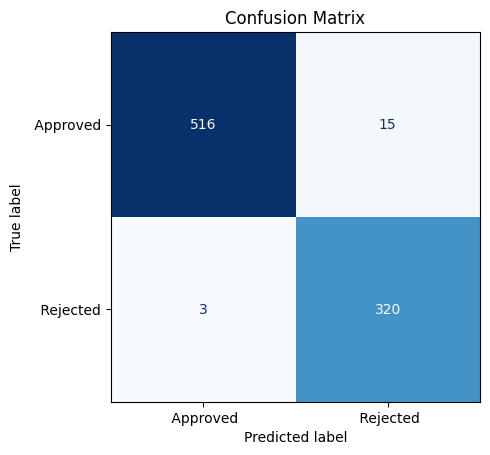

In [ ]:
y_pred = model.predict(X_test)
print("\n=== Metrics ===")
print(f"Accuracy : {accuracy_score(y_test,y_pred):.3f}")
# Specify the positive label
print(f"Precision: {precision_score(y_test,y_pred,pos_label=' Approved', zero_division=0):.3f}")
# Specify the positive label
print(f"Recall   : {recall_score(y_test,y_pred,pos_label=' Approved', zero_division=0):.3f}")
# Specify the positive label
print(classification_report(y_test,y_pred,zero_division=0))

ConfusionMatrixDisplay.from_predictions(y_test,y_pred,cmap="Blues",colorbar=False)
plt.title("Confusion Matrix"); plt.show()

In [ ]:
stamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
fname = f"loan_decision_tree_{stamp}.pkl"
stamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
fname = f"loan_decision_tree_{stamp}.pkl"
joblib.dump(model,fname)
print("Model saved ➜", fname)
files.download(fname)

Model saved ➜ loan_decision_tree_20250518_045604.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
from google.colab import files

print("📁 Please upload your .pkl model file:")
uploaded = files.upload()  # This will prompt you to select and upload the file

# Confirm the file is uploaded
for name in uploaded.keys():
    print(f"✅ Uploaded: {name}")



📁 Please upload your .pkl model file:


Saving loan_decision_tree_20250518_045604.pkl to loan_decision_tree_20250518_045604.pkl
✅ Uploaded: loan_decision_tree_20250518_045604.pkl


In [9]:
# %%
print("Please choose your loan_approval_dataset.csv …")
uploaded = files.upload()                # opens a file-picker dialog
csv_name = next(iter(uploaded))          # first uploaded file
df = pd.read_csv(csv_name)

print(f"\nDataset loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")
display(df.head())

Please choose your loan_approval_dataset.csv …


Saving loan_approval_dataset.csv to loan_approval_dataset.csv

Dataset loaded: 4,269 rows × 13 columns


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [11]:
import pandas as pd
import joblib
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

# Step 1: Load the model (assumes model was saved as a pipeline with preprocessing)
model = joblib.load("loan_decision_tree_20250518_045604.pkl")

# Step 2: Define the columns expected by the model's preprocessor
# You need to know the original feature columns from your training data (X).
# Based on your previous code, the original columns in X were likely:
# ['loan_id', 'no_of_dependents', 'education', 'self_employed',
#  'income_annum', 'loan_amount', 'loan_term', 'cibil_score',
#  'residential_assets_value', 'commercial_assets_value',
#  'luxury_assets_value', 'bank_asset_value']
# We need to include 'loan_id' even if it's not in your sample_input
original_feature_cols = ['loan_id', 'no_of_dependents', 'education', 'self_employed',
                         'income_annum', 'loan_amount', 'loan_term', 'cibil_score',
                         'residential_assets_value', 'commercial_assets_value',
                         'luxury_assets_value', 'bank_asset_value']


# Step 3: Sample input (don't include 'loan_id' here as it's not part of the input values)
sample_input_values = {
    'no_of_dependents': 2,
    'education': 'Graduate',
    'self_employed': 'No',
    'income_annum': 600000,
    'loan_amount': 250000,
    'loan_term': 120,
    'cibil_score': 750,
    'residential_assets_value': 500000,
    'commercial_assets_value': 200000,
    'luxury_assets_value': 100000,
    'bank_asset_value': 150000
}

# Step 4: Create the DataFrame with ALL original feature columns, filling in
# the provided sample values and using a placeholder for missing ones like 'loan_id'.
# Using None or np.nan for 'loan_id' is usually fine as it wasn't used in training.
sample_data = {col: [sample_input_values.get(col, None)] for col in original_feature_cols}
sample_df = pd.DataFrame(sample_data)

# Ensure the column order matches the original training data is good practice,
# although pandas generally handles column names correctly with ColumnTransformer.
sample_df = sample_df[original_feature_cols]


# Step 5: Predict
prediction = model.predict(sample_df)
# Assuming your model was trained on ' Approved' and ' Rejected' strings
print("✅ Loan Approval Prediction:", "Approved" if prediction[0].strip() == 'Approved' else "Rejected")


✅ Loan Approval Prediction: Approved


In [12]:
sample_input = {
    "loan_id": 1,                    # dummy ID
    "no_of_dependents": 4,
    "education": "Not Graduate",
    "self_employed": "Yes",
    "income_annum": 150000,
    "loan_amount": 500000,          # high compared to income
    "loan_term": 240,
    "cibil_score": 450,             # very low
    "residential_assets_value": 0,
    "commercial_assets_value": 0,
    "luxury_assets_value": 0,
    "bank_asset_value": 0,
}


In [13]:
import pandas as pd
import joblib

# Load model
model = joblib.load("loan_decision_tree_20250518_045604.pkl")

# Get expected feature columns
expected_cols = list(model.named_steps["pre"].feature_names_in_)

# Use the rejection-scenario input
sample_input = {
    "loan_id": 1,
    "no_of_dependents": 4,
    "education": "Not Graduate",
    "self_employed": "Yes",
    "income_annum": 150000,
    "loan_amount": 500000,
    "loan_term": 240,
    "cibil_score": 450,
    "residential_assets_value": 0,
    "commercial_assets_value": 0,
    "luxury_assets_value": 0,
    "bank_asset_value": 0,
}

sample_df = pd.DataFrame([sample_input])[expected_cols]

# Predict
pred_num = model.predict(sample_df)[0]
pred_label = "Approved" if pred_num == 1 else "Rejected"

print("\n📢 Loan Approval Prediction:", pred_label)



📢 Loan Approval Prediction: Rejected
